In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

class TreeNode():
    left = None
    right = None
    attribute = None
    splitter = None
    depth = None
    examples = None
    label = None
    flag = None
    def __init__(self,depth,examples):
        self.depth = depth
        self.examples = examples

class DecisionTree():
    max_depth = 0
    tree = None
    def __init__(self,max_depth):
        self.max_depth = max_depth

    def fit(self,X,y):
        if len(X)!=len(y):
            print("Length does not match")
            return
        #replace NAN with most common value of the column
        X.apply(lambda x: x.fillna(x.value_counts().idxmax()),axis=0)
        self.tree = treeGenerator(X,y,0,self.max_depth)
        return self

    def predict(self,T):
        curr = self.tree
        y_predicted = []
        for i in range(0,len(T)):
            while curr.label==None:
                if T.iloc[i][curr.attribute]<curr.splitter:
                    curr = curr.left
                else:
                    curr = curr.right
            y_predicted.append(curr.label)
        return y_predicted

    def print(self):
        queue = deque([self.tree])
        while queue:
            curr = queue.popleft()
            print("depth: "+str(curr.depth))
            if curr.label:
                print("type: leaf")
                print("class: "+str(curr.label))
            else:
                print("type: internal")
            if curr.attribute:
                print("column "+str(curr.attribute)+"<"+str(curr.splitter)+"?")
            if curr.left:
                queue.append(curr.left)
            if curr.right:
                queue.append(curr.right)

#grow tree that fits the training set
def treeGenerator(X,y,depth,max_depth):
    if len(set(y))==1 or depth==max_depth:
        leaf = TreeNode(depth,X)
        leaf.label = y.value_counts().idxmax() ##the most common value in y
        return leaf
    else:
        root = TreeNode(depth,X)
        X_left,X_right,root.attribute,root.splitter = findBestSplit(X,y)
        y_left = y[X_left.index.values]
        y_right = y[X_right.index.values]
        root.left = treeGenerator(X_left,y_left,depth+1,max_depth)
        root.right = treeGenerator(X_right,y_right,depth+1,max_depth)
        return root


#每一层的attribute可以重复用，所以每次都要搜索最好的splitter,data only contains binary variables
# and continuous variables,using information entropy as splitting rull
def findBestSplit(X,y):
    min = float('inf')
    selectedAttr = X.columns[0]
    splitter = 0
    for attr in X.columns.values:
        #print(attr)
        X_sort = X.sort_values([attr])
        l = len(X_sort)
        prev = None
        #can do better!!!!!!!
        #TODO: check binary column
        for i in range(1,l):
            if np.any(X_sort.iloc[i,attr]==prev): #no need to recalculate the same value
                continue
            left = X_sort.iloc[:i]
            right = X_sort.iloc[i:]
            leftSet = pd.value_counts(y[left.index])
            rightSet = pd.value_counts(y[right.index])
            leftEntropy = 0
            rightEntropy = 0
            sumLeft = sum(leftSet)
            sumRight = sum(rightSet)
            for val in leftSet:
                p = val/sumLeft
                leftEntropy -= p * np.log2(p)
            for val in rightSet:
                p = val/sumRight
                rightEntropy -= p * np.log2(p)
            Entropy = sumLeft/l * leftEntropy + sumRight/l * rightEntropy
            if Entropy<min:
                min = Entropy
                selectedAttr = attr
                splitter = X_sort.iloc[i][attr]
                X_left = left
                X_right = right
    return X_left, X_right,selectedAttr,splitter

In [3]:
def validation_curve():
    path = "arrhythmia.csv" #data file path
    n_attr = 5 # number of attribute used
    size = 451 #size of data used
    data = pd.read_csv(path, header=None)
    #Assign Binary values
    data = data.drop(range(n_attr, 279), 1)
    data = data.iloc[0:size]
    data_clean = data.replace('?', np.nan)  # replace '?' by NAN
    # replace NAN with most common value of the column
    data_clean  = data_clean.apply(lambda x: x.fillna(x.value_counts().idxmax()), axis=0)
    # randomly shuffle the dataset
    data_shuffle = data_clean.reindex(np.random.permutation(data_clean.index))
    length = len(data_shuffle)
    # partition 1
    data_1 = data_shuffle[:int(length / 3)]
    # partition 2
    data_2 = data_shuffle[int(length / 3):int(2 * length / 3)]
    # partition 3
    data_3 = data_shuffle[int(2 * length / 3):]
    data_train1 = data_1.append(data_2)  # use data1 & 2 as training set
    X_train1 = data_train1.iloc[:, :-1].copy()
    y_train1 = data_train1.iloc[:, -1].copy()
    X_test1 = data_3.iloc[:, :-1].copy()
    y_test1 = data_3.iloc[:, -1].copy()
    data_train2 = data_1.append(data_3)  # use data 1 & 3 as training set
    X_train2 = data_train2.iloc[:, :-1].copy()
    y_train2 = data_train2.iloc[:, -1].copy()
    X_test2 = data_2.iloc[:, :-1].copy()
    y_test2 = data_2.iloc[:, -1].copy()
    data_train3 = data_2.append(data_3)  # use data 2 & 3 as training set
    X_train3 = data_train3.iloc[:, :-1].copy()
    y_train3 = data_train3.iloc[:, -1].copy()
    X_test3 = data_1.iloc[:, :-1].copy()
    y_test3 = data_1.iloc[:, -1].copy()
    testAcc = []
    trainAcc = []
    for i in range(2, 21, 2):  # use different max depth
        #print(i)
        testavgacc = 0
        trainavgacc = 0
        dtree1 = DecisionTree(i)
        dtree1.fit(X_train1, y_train1)
        print("Decision Tree 1")
        dtree1.print()
        print("")
        y_train_pred1 = dtree1.predict(X_train1)
        y_test_pred1 = dtree1.predict(X_test1)
        #calculate the accuracy of tree1
        testavgacc += computeAccuracy(y_test_pred1, y_test1)
        trainavgacc += computeAccuracy(y_train_pred1,y_train1)
        dtree2 = DecisionTree(i)
        dtree2.fit(X_train2, y_train2)
        print("Decision Tree 2")
        dtree2.print()
        print("")
        y_train_pred2 = dtree2.predict(X_train2)
        y_test_pred2 = dtree2.predict(X_test2)
        #calculate the accuracy of tree2
        testavgacc += computeAccuracy(y_test_pred2, y_test2)
        trainavgacc += computeAccuracy(y_train_pred2,y_train2)
        dtree3 = DecisionTree(i)
        dtree3.fit(X_train3, y_train3)
        print("Decision Tree 3")
        dtree3.print()
        print("")
        y_train_pred3 = dtree3.predict(X_train3)
        y_test_pred3 = dtree3.predict(X_test3)
        #calculate the accuracy of tree3
        testavgacc += computeAccuracy(y_test_pred3, y_test3)
        trainavgacc += computeAccuracy(y_train_pred3,y_train3)
        testavgacc /= 3
        testAcc.append(testavgacc)
        trainavgacc /= 3
        trainAcc.append(trainavgacc)

    # plot cvAcc
    plt.plot(range(2, 21, 2), testAcc)
    plt.plot(range(2, 21, 2), trainAcc)
    plt.legend(['Testing Accuracy', 'Training accuracy'], loc = 'best')
    plt.savefig('hw1_validation_curve.png')
    plt.show()
    plt.close()

def computeEntropy(leftSet,rightSet,l):
    leftEntropy = 0
    rightEntropy = 0
    sumLeft = sum(leftSet)
    sumRight = sum(rightSet)
    for val in leftSet:
        p = val / sumLeft
        leftEntropy -= p * np.log2(p)
    for val in rightSet:
        p = val / sumRight
        rightEntropy -= p * np.log2(p)
    Entropy = sumLeft / l * leftEntropy + sumRight / l * rightEntropy
    return Entropy

def computeAccuracy(pred, real):
    a = 0
    l = len(real)
    for i in range(l):
        if (pred[i] == real.iloc[i]):
            a = a + 1
    return a / l

Decision Tree 1
depth: 0
type: internal
column 4<88?
depth: 1
type: internal
column 3<63?
depth: 1
type: internal
column 4<137?
depth: 2
type: leaf
class: 1
depth: 2
type: leaf
class: 1
depth: 2
type: leaf
class: 1
depth: 2
type: leaf
class: 9

Decision Tree 2
depth: 0
type: internal
column 4<95?
depth: 1
type: internal
depth: 1
type: internal
column 4<118?
depth: 2
type: leaf
class: 1
depth: 2
type: leaf
class: 1
depth: 2
type: leaf
class: 1
depth: 2
type: leaf
class: 10

Decision Tree 3
depth: 0
type: internal
column 4<95?
depth: 1
type: internal
column 1<0?
depth: 1
type: internal
column 4<121?
depth: 2
type: leaf
class: 1
depth: 2
type: leaf
class: 1
depth: 2
type: leaf
class: 10
depth: 2
type: leaf
class: 9

Decision Tree 1
depth: 0
type: internal
column 4<88?
depth: 1
type: internal
column 3<63?
depth: 1
type: internal
column 4<137?
depth: 2
type: internal
depth: 2
type: internal
depth: 2
type: internal
column 3<80?
depth: 2
type: leaf
class: 9
depth: 3
type: leaf
class: 5
depth:

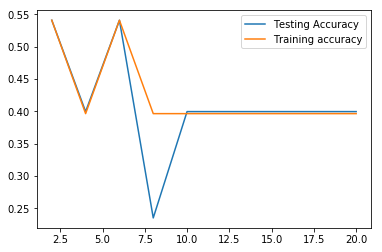

In [64]:
validation_curve()

In [4]:
path = "arrhythmia.csv" #data file path
n_attr = 5 # number of attribute used
size = 200 #size of data used
data = pd.read_csv(path, header=None)

In [85]:
a = [1,2,2]

In [86]:
a.value_counts()

AttributeError: 'set' object has no attribute 'value_counts'

In [80]:
X_sort

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
316,0,0,608,10,83,126,232,128,60,125,...,-0.7,4.5,-5.5,0.0,0.0,0.5,2.5,-11.8,1.7,5
60,1,0,110,10,80,121,287,156,67,126,...,-0.5,5.1,-4.8,0.0,0.0,0.8,0.9,-1.8,5.2,5
141,1,1,780,6,85,165,237,150,106,88,...,0.0,5.0,-4.6,0.0,0.0,1.3,0.7,2.7,5.5,5
320,3,0,105,12,69,155,240,133,64,93,...,0.0,3.3,0.0,0.0,0.0,1.1,-0.1,5.9,5.4,5
297,7,1,130,30,131,161,377,216,100,155,...,-0.6,3.3,-1.2,0.0,0.0,0.8,3.0,0.8,35.0,10
424,7,0,119,21,140,157,438,226,81,-40,...,0.0,10.0,-2.1,0.0,0.0,1.0,5.5,36.7,115.9,9
403,7,1,127,22,185,204,284,123,72,-172,...,0.0,3.9,-15.0,0.0,0.0,-0.8,3.6,-36.6,-20.1,5
379,8,0,120,28,118,126,303,164,80,120,...,-0.6,12.5,-3.6,0.0,0.0,0.5,2.3,9.2,32.2,10
429,8,1,130,24,77,125,358,159,70,87,...,0.0,11.3,-2.1,0.0,0.0,0.7,3.6,16.1,49.2,16
401,9,0,120,25,95,118,347,156,66,84,...,-1.9,16.5,-1.4,0.0,0.0,0.4,3.0,25.3,49.9,14


In [75]:
attr = data.columns.values[0]

In [77]:
X_sort.iloc[0][attr]==None

False

In [33]:
a

[1, 2]

In [35]:
a[1]

2

In [39]:
a = [2,4,6,8,10,12,14,16,18,20]

In [40]:
len(range(2,21,2))

10

In [41]:
len(a)

10

In [46]:
plt.plot(range(2,21,2),a,'o')

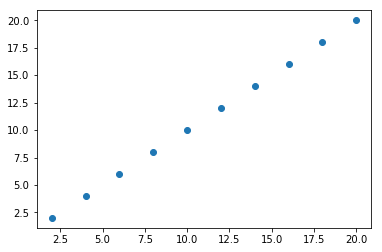

In [47]:
plt.show()

In [56]:
data1 = data[:1]

In [58]:
data2 = data[1:2]

In [61]:
data1.append(data2)


,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6


In [5]:
data

,0,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7
5,13,0,169,51,100,167,321,174,91,107,...,-0.6,12.2,-2.8,0.0,0.0,0.9,2.2,13.5,31.1,14
6,40,1,160,52,77,129,377,133,77,77,...,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5,1
7,49,1,162,54,78,0,376,157,70,67,...,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8,1
8,44,0,168,56,84,118,354,160,63,61,...,0.0,7.0,-1.3,0.0,0.0,0.6,2.1,12.5,30.9,1
9,50,1,167,67,89,130,383,156,73,85,...,-0.6,10.8,-1.7,0.0,0.0,0.8,0.9,20.1,25.1,10


In [8]:
data.iloc[0][0]

75

In [9]:
a = [1]

In [10]:
a.append(data.iloc[0][0])

In [11]:
a

[1, 75]

In [15]:
for counter in range(10, -1, -1):
    print(counter)

10
9
8
7
6
5
4
3
2
1
0


In [16]:
input = []

In [17]:
a = [1,2]
input.append(a)

In [18]:
input

[[1, 2]]

In [19]:
a = [1,2,3]

In [20]:
input

[[1, 2]]

In [21]:
input.append(a)

In [22]:
input

[[1, 2], [1, 2, 3]]

In [25]:
a = np.matrix([1,2,3]).transpose()

In [29]:
np.vstack([[1],a])

matrix([[1],
        [1],
        [2],
        [3]])